<a href="https://colab.research.google.com/github/LukeHaberkamp/AnomalyDetection/blob/main/EvaluateAutoencoderDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [104]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [105]:
model = tf.keras.models.load_model('./drive/My Drive/AutoencoderDetection/AutoencoderModel.h5', compile=False)

In [106]:
good_data_train = np.load('./drive/My Drive/AutoencoderDetection/Data/good_data_train.npy')
good_data_val = np.load('./drive/My Drive/AutoencoderDetection/Data/good_data_val.npy')
bad_data_val = np.load('./drive/My Drive/AutoencoderDetection/Data/bad_data_val.npy')

In [107]:
good_data_train_predict = model.predict(good_data_train, batch_size=32)

500/500 [==============================] - 11s 19ms/step


In [108]:
rolling_train_mse = []
for i in range(good_data_train.shape[0]):
    error = pd.Series((good_data_train[i] - good_data_train_predict[i]).squeeze())**2
    rolling_mse = error.rolling(window=30, center=True, min_periods=1).mean().values
    rolling_train_mse.append(rolling_mse)
rolling_train_mse = np.array(rolling_train_mse)
rolling_train_mse.shape

(16000, 512)

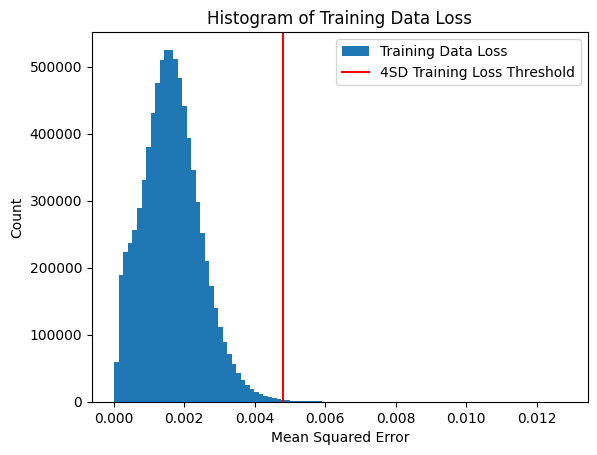

In [109]:
train_mse = rolling_train_mse.ravel()

threshold = np.quantile(train_mse, .9985)

plt.hist(train_mse, bins=100, label='Training Data Loss')
plt.axvline(x=threshold, color='r', label='4SD Training Loss Threshold')
plt.legend()
plt.title("Histogram of Training Data Loss")
plt.ylabel("Count")
plt.xlabel("Mean Squared Error")
plt.show()


In [110]:
def evaluate(data, val_type, val_idx):
    data_predict = model.predict(data, batch_size=32)

    rolling_val_mse = []
    for i in range(data.shape[0]):
        error = pd.Series((data[i] - data_predict[i]).squeeze())**2
        rolling_mse = error.rolling(window=30, center=True, min_periods=1).mean().values
        rolling_val_mse.append(rolling_mse)
    rolling_val_mse = np.array(rolling_val_mse)

    mse = rolling_val_mse.ravel()

    plt.hist(mse, bins=100, color='green')
    plt.axvline(x=threshold, color='r', linewidth=2)
    plt.title(f"Histogram of {val_type} Data Loss")
    plt.ylabel("Count")
    plt.xlabel("Mean Squared Error")
    plt.show()

    print('\n')

    plt.figure(figsize=(12,8))
    plt.subplot(2, 1, 1)
    plt.plot(data[val_idx], label='Raw')
    plt.plot(data_predict[val_idx], label='Reconstructed')

    for i in range(len(rolling_val_mse[val_idx])):
        if rolling_val_mse[val_idx][i] > threshold:
            plt.axvspan(i-0.5, i+0.5, color='gray', alpha=0.3, linewidth=0)

    plt.legend()
    plt.title(f"{val_type} - Raw & Reconstructed Data")
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(rolling_val_mse[val_idx], color='g', label='MSE')
    plt.axhline(y=threshold, color='r', label='4SD Training Loss Threshold')
    plt.legend()
    plt.title(f"{val_type} - Reconstruction Loss & Threshold")
    plt.xlabel('Time')
    plt.ylabel('Mean Squared Error')
    plt.show()

    print('\n')
    print('\n')

125/125 [==============================] - 3s 20ms/step


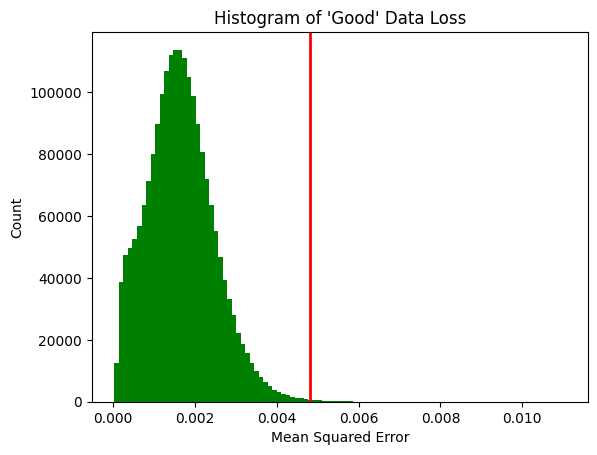

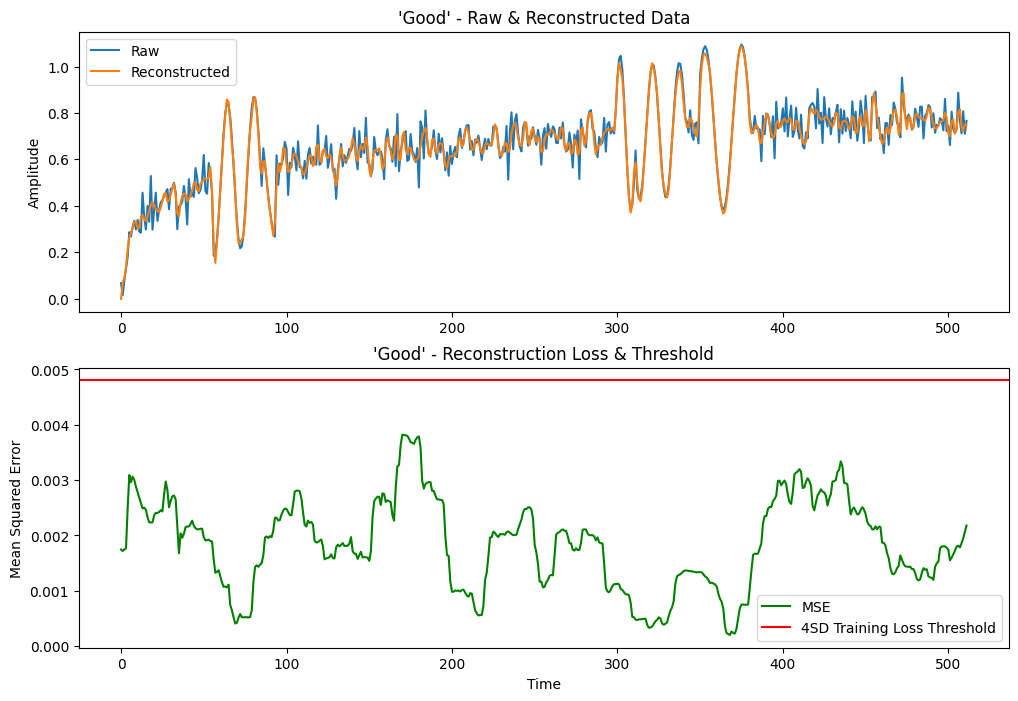





125/125 [==============================] - 3s 20ms/step


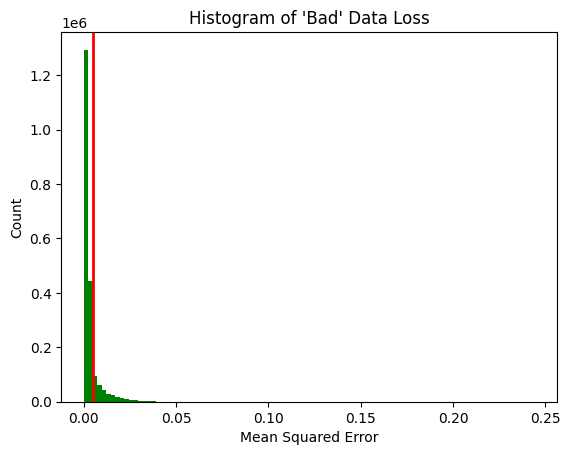

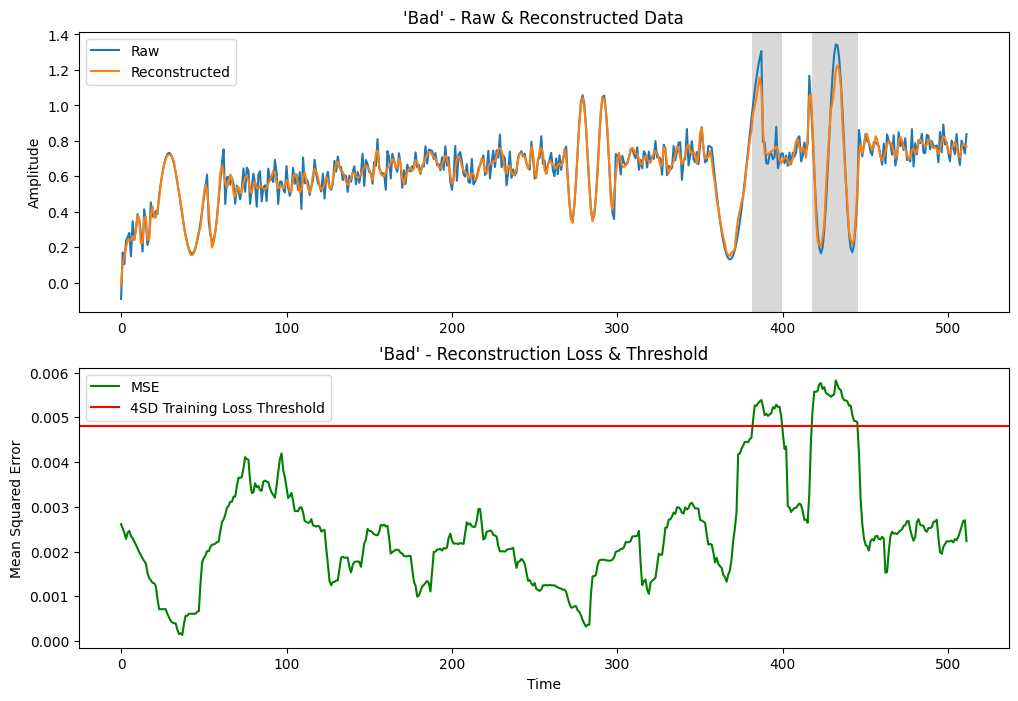

In [112]:
val_idx = 1

evaluate(good_data_val, val_type="'Good'", val_idx=val_idx)
evaluate(bad_data_val, val_type="'Bad'", val_idx=val_idx)